# One-Dimensional Climate Models: The Basics of Planets

In this tutorial you will learn the very basics of running 1D climate runs. For a more in depth look at the climate code check out [Mukherjee et al. 2023](https://ui.adsabs.harvard.edu/abs/2023ApJ...942...71M/abstract) (note this should also be cited if using this code/tutorial).

What you should already be familiar with:

- [basics of running/analyzing thermal spectra](https://natashabatalha.github.io/picaso/notebooks/A_basics/5_AddingThermalFlux.html)
- [how to analyze thermal emission spectra](https://natashabatalha.github.io/picaso/notebooks/workshops/ERS2021/ThermalEmissionTutorial.html)
- [how to compute a Brown Dwarf 1D climate model](https://natashabatalha.github.io/picaso/notebooks/D_climate/1_BrownDwarf_PreW.html)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# In this case, since we're not using the pre-weighted grid, we don't need to set a ck_db and we can just set the method to 'resortrebin'
opacity_ck = jdi.opannection(method='resortrebin')# grab your opacities

## Starting up the Run


You will notice that starting a run is nearly identical as running a spectrum and brown dwarf climate model. However, how we will add `climate=True` to our inputs flag. We will also specify `planet` in this case, which will turn on the irradiation the object is receiving.

New Parameter (was also used in the Brown Dwarf tutorial): **Effective Temperature**. This excerpt from [Modeling Exoplanetary Atmospheres (Fortney et al)](https://arxiv.org/pdf/1804.08149.pdf) provides a thorough description and more reading, if you are interested.

> If the effective temperature, $T_{eff}$, is defined as the temperature of a blackbody of
the same radius that would emit the equivalent flux as the real planet, $T_{eff}$ and $T_{eq}$
can be simply related. This relation requires the inclusion of a third temperature,
$T_{int}$, the intrinsic effective temperature, that describes the flux from the planet’s
interior. These temperatures are related by:

> $T_{eff}^4 =  T_{int}^4 + T_{eq}^4$

> We then recover our limiting cases: if a planet is self-luminous (like a young giant
planet) and far from its parent star, $T_{eff} \approx  T_{int}$; for most rocky planets, or any
planets under extreme stellar irradiation, $T_{eff} \approx T_{eq}$.

In [3]:
cl_run = jdi.inputs(calculation="planet", climate = True) # start a calculation

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation


tint= 200 # Intrinsic Temperature of your Planet in K
grav = 4.5 # Gravity of your Planet in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(tint) # input effective temperature

Let's now input the host-star properties

In [4]:
T_star =5326.6 # K, star effective temperature
logg =4.38933 #logg , cgs
metal =-0.03 # metallicity of star
r_star = 0.932 # solar radius
semi_major = 0.0486 # star planet distance, AU

cl_run.star(opacity_ck, temp =T_star,metal =metal, logg =logg, radius = r_star,
            radius_unit=u.R_sun,semi_major= semi_major , semi_major_unit = u.AU)#opacity db, pysynphot database, temp, metallicity, logg

## Initial T(P)  Guess

Every calculation requires an initial guess of the pressure temperature profile. The code will iterate from there to find the correct solution. A few tips:

1. We recommend **using typically 51-91 atmospheric pressure levels**. Too many pressure layers increases the computational time required for convergence. Too little layers makes the atmospheric grid too coarse for an accurate calculation.

2. Start with **a guess that is close to your expected solution**. One easy way to get fairly close is by using the Guillot et al 2010 temperature-pressure profile approximation


In [5]:
nlevel = 91 # number of plane-parallel levels in your code

#Lets set the max and min at 1e-4 bars and 500 bars
Teq=1000 # planet equilibrium temperature
pt = cl_run.guillot_pt(Teq, nlevel=nlevel, T_int = tint, p_bottom=2, p_top=-6)
temp_guess = pt['temperature'].values
pressure = pt['pressure'].values

## Initial Convective Zone Guess

You also need to have a crude guess of the convective zone of your atmosphere. Generally the deeper atmosphere is always convective. Again a good guess is always the published SONORA grid of models for this. But lets assume that the bottom 7 levels of the atmosphere is convective.

**New Parameters:**

1. `rfacv`: (See [Mukherjee et al. 2023](https://ui.adsabs.harvard.edu/abs/2023ApJ...942...71M/abstract) Eqn. 20 `r_st`)

Non-zero values of rst (aka "rfacv" legacy terminology) is only relevant when the external irradiation on the atmosphere is non-zero. In the scenario when a user is computing a planet-wide average T(P) profile, the stellar irradiation is contributing to 50% (one hemisphere) of the planet and as a result rst = 0.5. If instead the goal is to compute a night-side average atmospheric state, rst is set to be 0. On the other extreme, to compute the day-side atmospheric state of a tidally locked planet rst should be set at 1.

In [6]:
rcb_guess = 85 # top most level of guessed convective zone

# Here are some other parameters needed for the code.
rfacv = 0.5 #we are focused on a brown dwarf so let's keep this as is

Now we would use the inputs_climate function to input everything together to our cl_run we started.

In [7]:
cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure,
                      rcb_guess=rcb_guess, rfacv = rfacv)
mh=10#10xsolar
cto_relative = 1 #1xsolar
#now that we are not using preweighted ck tables we need to tell picaso how to compute chemistry on the fly
cl_run.atmosphere(mh=mh, cto_relative=cto_relative, chem_method='visscher')

## Run the Climate Code

 The actual climate code can be run with the cl_run.run command. The save_all_profiles is set to True to save the T(P) profile at all steps. The code will now iterate from your guess to reach the correct atmospheric solution for your brown dwarf of interest.



In [8]:
out = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)

SUMMARY
-------
Clouds: False
quench False
cold_trap False
vol_rainout False
no_ph3 False
Moist Adiabat: False


Iteration number  0 , min , max temp  859.0821042634918 2289.3589707978936 , flux balance  -5.2938855337191795
Iteration number  1 , min , max temp  834.2982383543513 2803.2438302826686 , flux balance  20.57565952032679


Iteration number  2 , min , max temp  833.1151579578335 2669.284671807511 , flux balance  0.3683315020487719
Iteration number  3 , min , max temp  833.1067906244208 2652.77243732339 , flux balance  0.0018999027751531983
Iteration number  4 , min , max temp  833.1067470839256 2652.503550380497 , flux balance  9.183142423169761e-06
In t_start: Converged Solution in iterations  4
Big iteration is  833.1067470839256 0


 We are already at a root, tolf , test =  5e-05 ,  1.2294269004647597e-05
Profile converged before itmx


Iteration number  0 , min , max temp  831.9908033804824 2749.632595807339 , flux balance  1.8623878560043345
Iteration number  1 , min , max temp  830.6676871516955 2840.8892894615296 , flux balance  0.21266303956741936


Iteration number  2 , min , max temp  830.6576752506554 2836.0100749905278 , flux balance  0.001207079224932915
In t_start: Converged Solution in iterations  2
Big iteration is  830.6576752506554 0


Iteration number  0 , min , max temp  830.6576222743299 2835.984738237336 , flux balance  6.305564318563136e-06
In t_start: Converged Solution in iterations  0
Profile converged before itmx


Iteration number  0 , min , max temp  830.2162732115787 2845.136632022439 , flux balance  0.015389109233956736
Iteration number  1 , min , max temp  830.2128019297813 2843.4671061456297 , flux balance  9.185663718567617e-05
In t_start: Converged Solution in iterations  1
Big iteration is  830.2128019297813 0


Iteration number  0 , min , max temp  830.2127848570326 2843.4614699886083 , flux balance  5.194035631592011e-07
In t_start: Converged Solution in iterations  0
Profile converged before itmx


Iteration number  0 , min , max temp  829.9813229566977 2815.0270018443825 , flux balance  0.0009186031491667133
In t_start: Converged Solution in iterations  0
Big iteration is  829.9813229566977 0


Iteration number  0 , min , max temp  829.9800345196018 2815.0264630987213 , flux balance  6.062141435236924e-06
In t_start: Converged Solution in iterations  0
Profile converged before itmx
final [0, 83, 89, 0, 0, 0]


Iteration number  0 , min , max temp  829.9142317946252 2815.458464159451 , flux balance  0.00029724571471210186
In t_start: Converged Solution in iterations  0
Big iteration is  829.9142317946252 0


Iteration number  0 , min , max temp  829.9139027072954 2815.4594348336927 , flux balance  1.5118646463673696e-06
In t_start: Converged Solution in iterations  0
Profile converged before itmx
YAY ! ENDING WITH CONVERGENCE


Text(0.5, 1.0, 'T$_{\\rm eff}$= 1000 K, log(g)=5.0')

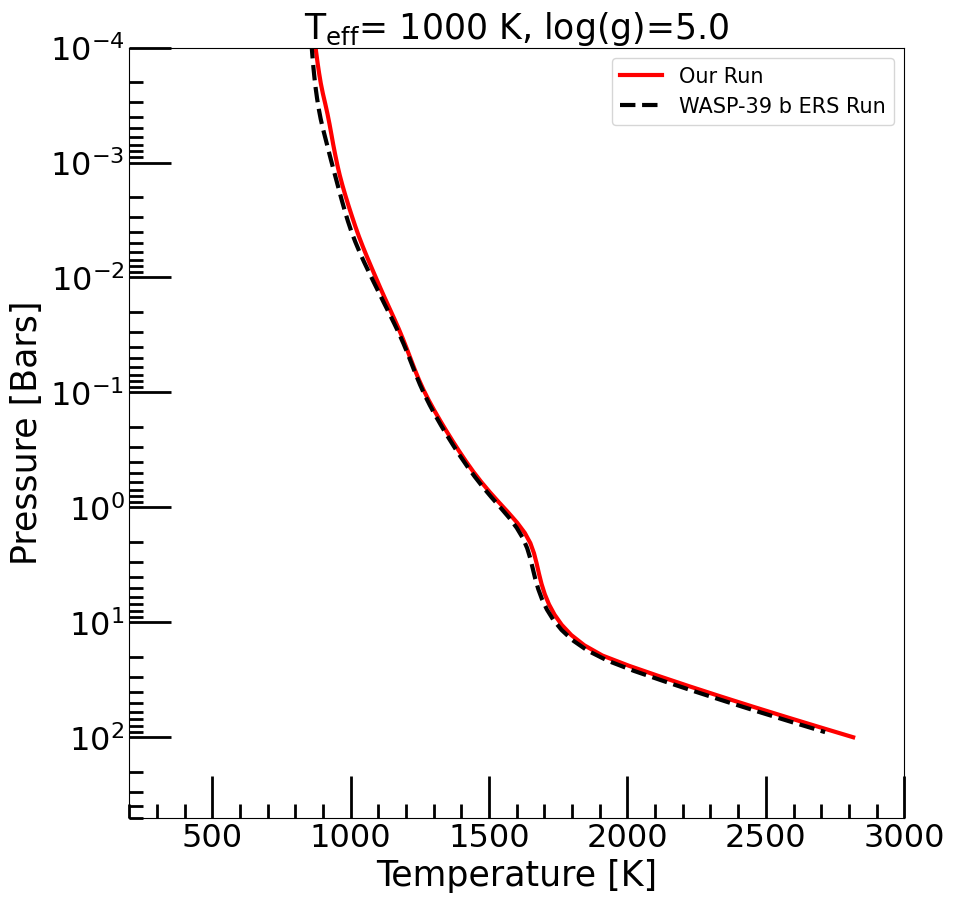

In [9]:
base_case = jdi.pd.read_csv(jdi.HJ_pt(), sep=r'\s+')

plt.figure(figsize=(10,10))
plt.ylabel("Pressure [Bars]", fontsize=25)
plt.xlabel('Temperature [K]', fontsize=25)
plt.ylim(500,1e-4)
plt.xlim(200,3000)

plt.semilogy(out['temperature'],out['pressure'],color="r",linewidth=3,label="Our Run")

plt.semilogy(base_case['temperature'],base_case['pressure'],color="k",linestyle="--",linewidth=3,label="WASP-39 b ERS Run")


plt.minorticks_on()
plt.tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
plt.tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)

plt.legend(fontsize=15)

plt.title(r"T$_{\rm eff}$= 1000 K, log(g)=5.0",fontsize=25)



### Brightness Temperature

Checking the brightness temperature serves many useful purposes:

1. Intuition building. Allows you to see what corresponding temperature are you sensitive to at each wavelength

Note that this temperature doesn't need to be the physical temperature of your atmosphere but if you can find the physical converged atmospheric temperature closest to this brightness temperature you can also get an idea of the atmospheric pressure from where the flux you are seeing is originating from.

2. Determining if your choice in bottom boundary pressure grid was correct.

If your brightness temperature is such that you bottom out at the temperature corresponding to the highest pressure, you have not extended your grid to high enough pressures.

Brightness Temperature Equation:

$T_{\rm bright}=\dfrac{a}{{\lambda}log\left(\dfrac{{b}}{F(\lambda){\lambda}^5}+1\right)}$

where a = 1.43877735$\times$10$^{-2}$ m.K and b = 11.91042952$\times$10$^{-17}$ m$^4$kg/s$^3$

Let's calculate the brightness temperature of our current run and check if our pressure grid was okay.

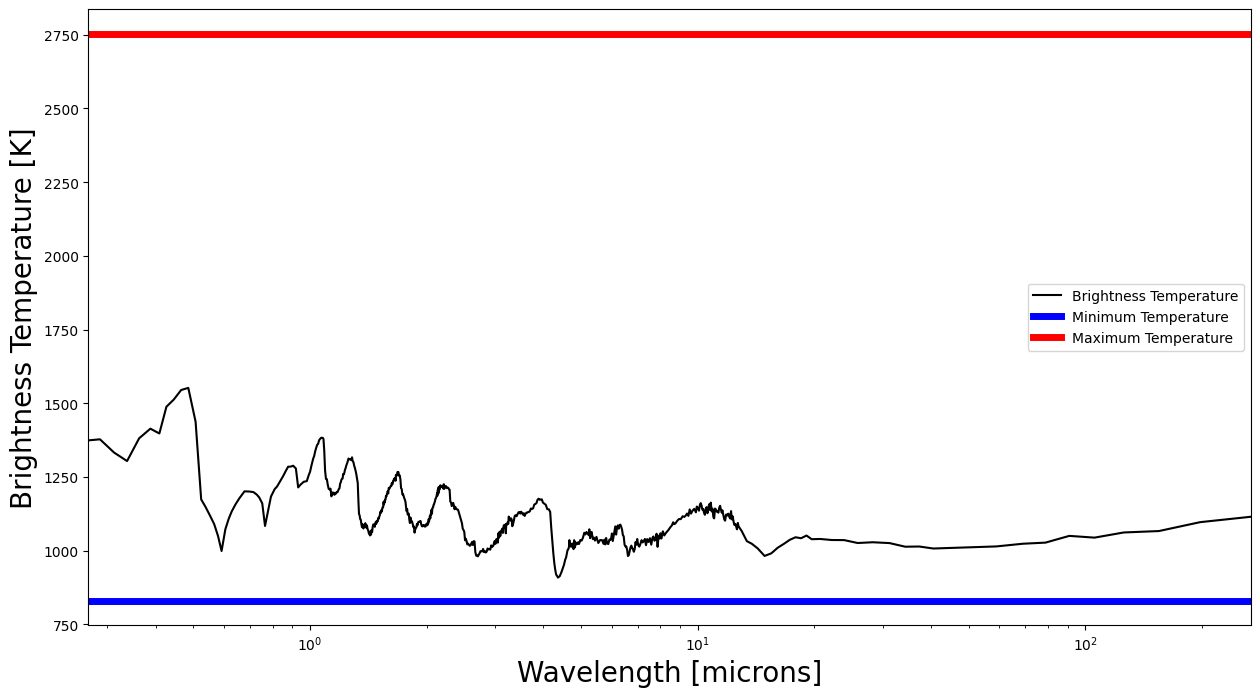

In [10]:
brightness_temp, figure= jpi.brightness_temperature(out['spectrum_output'])

### Check Adiabat

This plot and datareturn is helpful to check that there have been no issues with where the code has found the location of the convective zone(s). See below, dTdP never exceeds the adiabat.

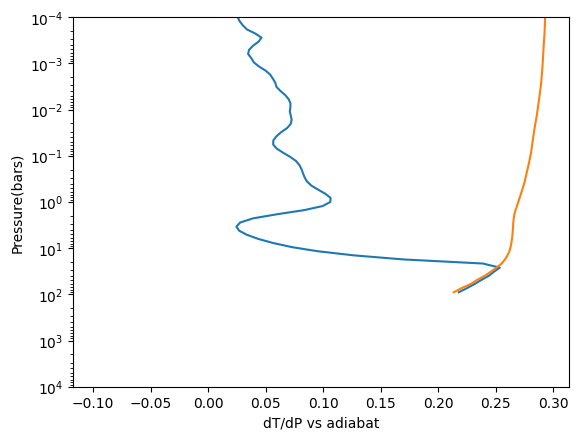

In [11]:
cp, adiabat, dtdp, pressure = jpi.pt_adiabat(out, cl_run, opacity_ck, plot=True)

In [12]:
jdi.output_xarray(out,cl_run,savefile='w39.nc')

<xarray.Dataset> Size: 66kB
Dimensions:         (pressure: 91, pressure_layer: 90, wavelength: 661)
Coordinates:
  * pressure        (pressure) float64 728B 1e-06 1.227e-06 ... 81.49 100.0
  * pressure_layer  (pressure_layer) float64 720B 1.108e-06 1.359e-06 ... 90.27
  * wavelength      (wavelength) float64 5kB 267.6 197.9 154.9 ... 0.287 0.2679
Data variables: (12/75)
    temperature     (pressure) float64 728B 867.0 849.7 ... 2.693e+03 2.815e+03
    dtdp            (pressure_layer) float64 720B -0.09816 -0.01994 ... 0.2179
    guess 1         (pressure) float64 728B 861.5 861.5 ... 1.876e+03 1.933e+03
    guess 2         (pressure) float64 728B 861.5 861.5 ... 2.114e+03 2.226e+03
    guess 3         (pressure) float64 728B 861.5 861.5 ... 2.114e+03 2.226e+03
    guess 4         (pressure) float64 728B 862.0 860.4 ... 2.176e+03 2.289e+03
    ...              ...
    Mg+             (pressure) float64 728B 2.814e-40 1.064e-41 ... 2.818e-10
    Si              (pressure) float64 728B 6.236e-31 4.349e-32 ... 7.88e-07
    Fe+             (pressure) float64 728B 2.123e-38 1.019e-39 ... 6.34e-11
    Ti              (pressure) float64 728B 8.49e-34 5.267e-35 ... 1.139e-07
    Ti+             (pressure) float64 728B 1e-50 1e-50 ... 4.912e-13 1.551e-12
    C+              (pressure) float64 728B 1e-50 1e-50 ... 3.217e-25 5.208e-24
Attributes:
    climate_params:  {"cvs_locs": [0, 83, 89, 0, 0, 0], "converged": 1}
    planet_params:   {"effective_temp": 1106.7644414996128, "gravity": {"valu...
    stellar_params:  {"database": "ck04models", "steff": 5326.6, "feh": -0.03...
    orbit_params:    {"sma": {"value": 727045651602.0, "unit": "cm"}}